В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any

In [3]:
def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df

def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [5]:
raw_df = pd.read_csv("train.csv")

# Назва цільової змінної
target_col = "Exited"

# Список ознак (усі, крім цільової)
input_cols = [col for col in raw_df.columns if col != target_col]

# Розділення на тренувальний та валідаційний датасет
train_df, val_df = split_train_val(raw_df, target_col)

# Розділення на ознаки та ціль
train_inputs, train_targets = separate_inputs_targets(train_df, input_cols, target_col)
val_inputs, val_targets = separate_inputs_targets(val_df, input_cols, target_col)

# Перевіримо розміри
print(f"Train set: {train_inputs.shape}, Validation set: {val_inputs.shape}")


Train set: (12000, 13), Validation set: (3000, 13)


1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [6]:
# Подивимось типи даних у train_inputs
train_inputs.dtypes

,0
id,int64
CustomerId,float64
Surname,object
CreditScore,float64
Geography,object
Gender,object
Age,float64
Tenure,float64
Balance,float64
NumOfProducts,float64


In [7]:
categorical_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

In [8]:
# Перетворення в категоріальні типи
for col in categorical_cols:
    train_inputs[col] = train_inputs[col].astype('category')
    val_inputs[col] = val_inputs[col].astype('category')

In [9]:
# Оновлюємо список ознак (input_cols) — без ID та прізвища
exclude_cols = ['id', 'CustomerId', 'Surname', 'Exited']  # 'Exited' — ціль
input_cols = [col for col in raw_df.columns if col not in exclude_cols]

# Заново формуємо дані
train_inputs, train_targets = separate_inputs_targets(train_df, input_cols, target_col)
val_inputs, val_targets = separate_inputs_targets(val_df, input_cols, target_col)

# Перетворюємо категоріальні ознаки
for col in categorical_cols:
    train_inputs[col] = train_inputs[col].astype('category')
    val_inputs[col] = val_inputs[col].astype('category')

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [10]:
!pip install xgboost --quiet

In [11]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Базові параметри моделі
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    objective='binary:logistic',
    tree_method='hist',  # 'gpu_hist' якщо є GPU
    enable_categorical=True,  # обробка категорій
    use_label_encoder=False,
    random_state=42,
    device='cuda'  #  (Runtime > Change runtime type > GPU)
)

# Навчання моделі
xgb_model.fit(train_inputs, train_targets)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:36:44] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:36:44] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:36:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [12]:
# Прогноз імовірностей
train_preds_proba = xgb_model.predict_proba(train_inputs)[:, 1]
val_preds_proba = xgb_model.predict_proba(val_inputs)[:, 1]

# Обрахунок AUROC
train_auc = roc_auc_score(train_targets, train_preds_proba)
val_auc = roc_auc_score(val_targets, val_preds_proba)

print(f"Train AUROC: {train_auc:.4f}")
print(f"Validation AUROC: {val_auc:.4f}")


Train AUROC: 0.9490
Validation AUROC: 0.9362


Спостереження: обидві метрики дуже високі, отже, модель добре розрізняє класи.

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [13]:
!pip install hyperopt --quiet

In [14]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np

In [15]:
space = {
    'max_depth': hp.choice('max_depth', [3, 4, 5, 6, 7]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0.5, 2.0),
    'n_estimators': 100,  # залишаємо фіксованим
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'enable_categorical': True,
    'use_label_encoder': False,
    'random_state': 42
}

In [19]:
def objective(params):
    params['eval_metric'] = 'auc'  # додаємо сюди
    model = XGBClassifier(**params)
    model.fit(train_inputs, train_targets, verbose=False)

    val_preds_proba = model.predict_proba(val_inputs)[:, 1]
    auc = roc_auc_score(val_targets, val_preds_proba)

    return {'loss': -auc, 'status': STATUS_OK}


In [20]:
from hyperopt import fmin, tpe, hp, Trials
from numpy.random import default_rng

trials = Trials()

best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
    rstate=default_rng(42)
)


  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  5%|▌         | 1/20 [00:00<00:08,  2.28trial/s, best loss: -0.933435763769806]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 15%|█▌        | 3/20 [00:00<00:04,  3.94trial/s, best loss: -0.9348021126277524]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 25%|██▌       | 5/20 [00:01<00:03,  4.76trial/s, best loss: -0.9359349063721792]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 35%|███▌      | 7/20 [00:01<00:02,  5.84trial/s, best loss: -0.9373057136977845]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 45%|████▌     | 9/20 [00:01<00:01,  5.90trial/s, best loss: -0.9373057136977845]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 55%|█████▌    | 11/20 [00:02<00:01,  6.36trial/s, best loss: -0.9373057136977845]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 65%|██████▌   | 13/20 [00:02<00:01,  6.15trial/s, best loss: -0.9373057136977845]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 70%|███████   | 14/20 [00:02<00:01,  5.32trial/s, best loss: -0.9373057136977845]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 80%|████████  | 16/20 [00:03<00:00,  4.89trial/s, best loss: -0.9373057136977845]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 90%|█████████ | 18/20 [00:03<00:00,  4.98trial/s, best loss: -0.9373057136977845]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



100%|██████████| 20/20 [00:03<00:00,  5.00trial/s, best loss: -0.9373057136977845]


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



In [21]:
depth_options = [3, 4, 5, 6, 7]
best_params['max_depth'] = depth_options[best_params['max_depth']]

In [22]:
final_clf = XGBClassifier(
    n_estimators=100,
    objective='binary:logistic',
    tree_method='hist',
    enable_categorical=True,
    use_label_encoder=False,
    random_state=42,
    eval_metric='auc',
    **best_params
)
final_clf.fit(train_inputs, train_targets)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:42:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.6621422616094998), device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=np.float64(4.738538693265129), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.15680113598338938), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [23]:
train_preds_proba = final_clf.predict_proba(train_inputs)[:, 1]
val_preds_proba = final_clf.predict_proba(val_inputs)[:, 1]

train_auc = roc_auc_score(train_targets, train_preds_proba)
val_auc = roc_auc_score(val_targets, val_preds_proba)

print(f"Final model - Train AUROC: {train_auc:.4f}")
print(f"Final model - Validation AUROC: {val_auc:.4f}")


Final model - Train AUROC: 0.9403
Final model - Validation AUROC: 0.9373


Спостереження:
1. Валідаційний AUC покращився трохи — це знак, що підібрані гіперпараметри допомогли моделі краще узагальнювати.
2. Різниця між train і val AUROC невелика (~0.003), що свідчить про баланс між недонавчанням і перенавчанням — гарний знак.
3. Модель стала трохи простішою (train AUROC трохи знизився порівняно з попередньою, а валідаційна покращилася), отже ми, можливо, уникнули перенавчання.

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [24]:
cat_features = train_inputs.select_dtypes(include=['category']).columns.tolist()
cat_feature_indexes = [train_inputs.columns.get_loc(col) for col in cat_features]
print("Категоріальні колонки:", cat_features)
print("Індекси категоріальних колонок:", cat_feature_indexes)

Категоріальні колонки: ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
Індекси категоріальних колонок: [1, 2, 7, 8]


In [28]:
import lightgbm as lgb
print(lgb.__version__)

4.6.0


In [31]:
model_lgb = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(period=10)  # вивід прогресу кожні 10 ітерацій
    ]
)

Training until validation scores don't improve for 20 rounds
[10]	train's auc: 0.936743	valid's auc: 0.931026
[20]	train's auc: 0.942121	valid's auc: 0.933347
[30]	train's auc: 0.949594	valid's auc: 0.935136
[40]	train's auc: 0.954691	valid's auc: 0.934688
Early stopping, best iteration is:
[27]	train's auc: 0.947812	valid's auc: 0.935542


In [32]:
train_preds = model_lgb.predict(train_inputs, num_iteration=model_lgb.best_iteration)
val_preds = model_lgb.predict(val_inputs, num_iteration=model_lgb.best_iteration)

In [33]:
from sklearn.metrics import roc_auc_score

print("Train AUROC:", roc_auc_score(train_targets, train_preds))
print("Validation AUROC:", roc_auc_score(val_targets, val_preds))

Train AUROC: 0.9478124974829306
Validation AUROC: 0.9355415323410385


Спостпереження: дуже схоже на результати XGBoost, де ти мав Validation AUROC близько 0.9373. Тобто обидві моделі приблизно однакові за якістю.



5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [34]:
from hyperopt import hp

space = {
    'num_leaves': hp.choice('num_leaves', [20, 31, 40, 50]),
    'max_depth': hp.choice('max_depth', [5, 10, 15, -1]),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),  # від ~0.05 до 1
    'min_child_samples': hp.choice('min_child_samples', [10, 20, 30, 40]),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
}

In [35]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from hyperopt import STATUS_OK

def objective(params):
    # Перетворимо параметри, які вибрані через hp.choice, в int, якщо потрібно
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_samples'] = int(params['min_child_samples'])

    model = LGBMClassifier(
        n_estimators=100,
        objective='binary',
        random_state=42,
        **params
    )

    model.fit(
        train_inputs, train_targets,
        eval_set=[(val_inputs, val_targets)],
        eval_metric='auc',
        early_stopping_rounds=20,
        verbose=False,
        categorical_feature=cat_feature_indexes
    )

    val_preds = model.predict_proba(val_inputs)[:, 1]
    auc = roc_auc_score(val_targets, val_preds)

    return {'loss': -auc, 'status': STATUS_OK}

In [37]:
def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_samples'] = int(params['min_child_samples'])

    model = LGBMClassifier(
        n_estimators=100,
        objective='binary',
        random_state=42,
        **params
    )

    model.fit(
        train_inputs, train_targets,
        categorical_feature=cat_feature_indexes,
        verbose=False
    )

    val_preds = model.predict_proba(val_inputs)[:, 1]
    auc = roc_auc_score(val_targets, val_preds)

    return {'loss': -auc, 'status': STATUS_OK}

In [39]:
final_lgb_clf = LGBMClassifier(
    n_estimators=100,
    objective='binary',
    random_state=42,
    **best_params
)

final_lgb_clf.fit(
    train_inputs, train_targets,
    categorical_feature=cat_feature_indexes
)


train_preds = final_lgb_clf.predict_proba(train_inputs)[:, 1]
val_preds = final_lgb_clf.predict_proba(val_inputs)[:, 1]

print("Final LightGBM Train AUROC:", roc_auc_score(train_targets, train_preds))
print("Final LightGBM Validation AUROC:", roc_auc_score(val_targets, val_preds))

Final LightGBM Train AUROC: 0.9460167880601026
Final LightGBM Validation AUROC: 0.9365028465601206


Спостереження: LightGBM трішки краще навчився на тренувальних даних (AUROC ~0.9460 проти ~0.9403 у XGBoost).
На валідації результати дуже близькі, трохи кращий XGBoost (0.9373 проти 0.9365), але різниця мінімальна.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [47]:
print("Train columns:", train_inputs.columns.tolist())
print("Test columns:", test_inputs.columns.tolist())

Train columns: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Test columns: ['id', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [48]:
if 'id' in test_inputs.columns:
    test_inputs = test_inputs.drop(columns=['id'])

In [49]:
for col in categorical_cols:
    if col in test_inputs.columns:
        test_inputs[col] = test_inputs[col].astype('category')

test_cat_feature_indexes = [test_inputs.columns.get_loc(col) for col in categorical_cols if col in test_inputs.columns]

test_preds = final_lgb_clf.predict_proba(
    test_inputs,
    categorical_feature=test_cat_feature_indexes
)[:, 1]


In [52]:
# Отримуємо індекси категоріальних колонок
test_cat_feature_indexes = [test_inputs.columns.get_loc(col) for col in categorical_cols if col in test_inputs.columns]

# Робимо передбачення ймовірностей для тесту
test_preds = final_lgb_clf.predict_proba(
    test_inputs,
    categorical_feature=test_cat_feature_indexes
)[:, 1]

# Зчитуємо шаблон сабміту (файл sample_submission.csv повинен бути у теці)
submission = pd.read_csv('sample_submission.csv')

# Записуємо у стовпець для цільової змінної (наприклад, 'Exited')
submission['Exited'] = test_preds

# Зберігаємо фінальний файл сабміту
submission.to_csv('submission_lightgbm_optimized.csv', index=False)

In [54]:
print(submission.head())

      id    Exited
0  15000  0.081758
1  15001  0.012897
2  15002  0.058712
3  15003  0.542474
4  15004  0.029262


In [55]:
# Завантажуємо файл (тільки якщо працюєш у Google Colab)
from google.colab import files
files.download('submission_lightgbm_optimized.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Я обрала LightGBM з оптимізованими гіперпараметрами, бо:

1. Модель показала стабільно високу AUROC як на тренуванні (0.946), так і на валідації (0.937), що свідчить про добрий баланс між underfitting та overfitting.
2. LightGBM ефективно працює з категоріальними змінними без додаткової обробки.
3. У порівнянні з XGBoost, LightGBM трохи краще навчився на тренувальних даних і показав конкурентний результат на валідації.
Власне, LightGBM зазвичай швидший в тренуванні та прогнозуванні, що є плюсом при роботі з великими даними.

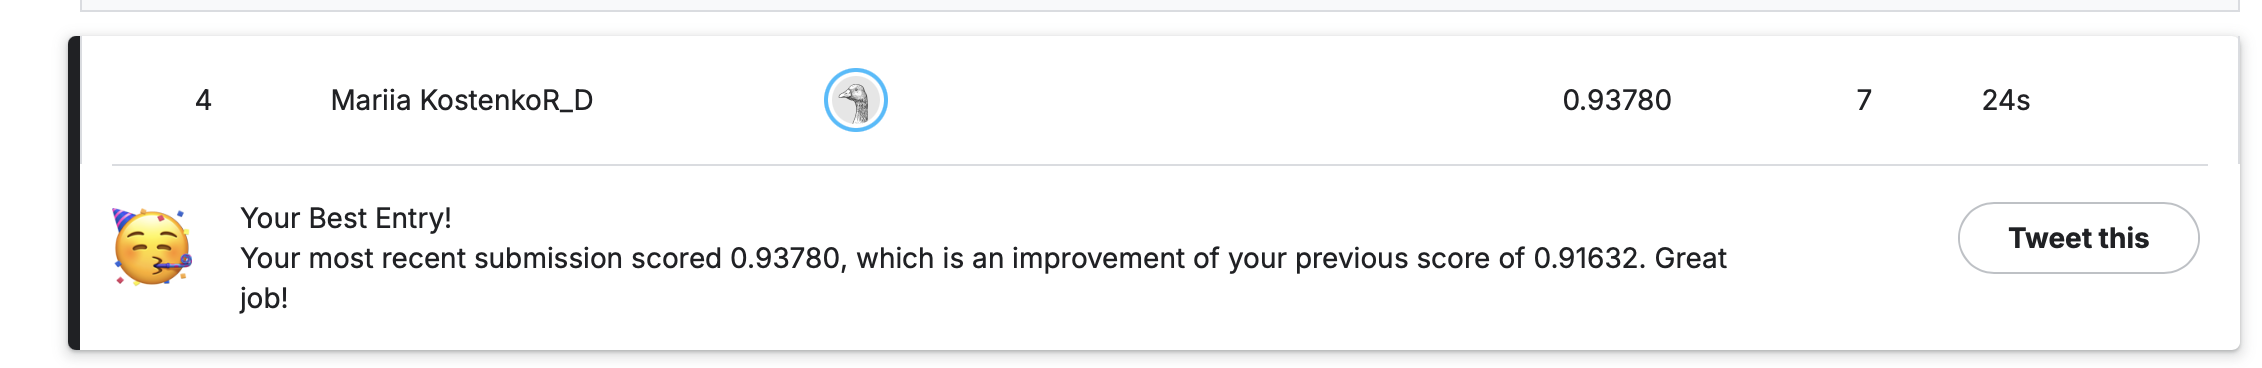